## Get the electricity data for the past three days

In [85]:
import requests as rq
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [125]:
pred_start = datetime(2019,10,25,0,6,0)
pred_end = datetime(2019,10,30,0,6,0)
start_day = 0
end_day = 5

In [126]:
# Current time
# now = datetime.now()
now = pred_end-timedelta(days=1)
# Time three days ago
three_days_ago = pred_start-timedelta(days=3)

In [127]:
end = now.strftime('%Y%m%dT%H-%M')
start = three_days_ago.strftime('%Y%m%dT%H-%M')
key = '8a6315646d5695061696c71a041c42c0'
series_id = 'EBA.NW-ALL.NG.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [128]:
usage_series_id = 'EBA.NW-ALL.D.HL'
usage_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, usage_series_id, start, end))

In [129]:
hourly_demand = data.json()['series'][0]['data']
electricity_demand = pd.DataFrame(hourly_demand, columns=['datetime','net_gen'])
electricity_usage = pd.DataFrame(usage_data.json()['series'][0]['data'], columns=['datetime', 'usage'])
electricity_demand = electricity_demand.merge(electricity_usage, how='right', left_on='datetime', right_on='datetime')
electricity_demand = electricity_demand.sort_values(['datetime']).reset_index(drop=True)

In [130]:
electricity_demand.head(5)

,datetime,net_gen,usage
0,20191022T00-06,36200.0,34997
1,20191022T01-06,34624.0,33145
2,20191022T02-06,34335.0,32058
3,20191022T03-06,33368.0,31359
4,20191022T04-06,32662.0,31024


In [131]:
electricity_demand.tail(1)

,datetime,net_gen,usage
168,20191029T00-06,NaN,39114


In [132]:
def diff_in_hours(x):
    # This function returns the number of hours from 2015-07-01 01:05:00
    minutes = (x-datetime(2015, 7, 1, 1, 6, 0)).total_seconds()/60
    if minutes % 60 > 30:
        return minutes/60 + 1
    else:
        return minutes/60
    
df_for_periodic_model = electricity_demand.copy()
df_for_periodic_model['datetime'] = pd.to_datetime(df_for_periodic_model['datetime'], format='%Y%m%dT%H-%M')
df_for_periodic_model['hours'] = df_for_periodic_model['datetime'].apply(lambda x: diff_in_hours(x))

# Construct the sin and cos columns.
def trig(func, period, x):
    # This function returns a sin or x value of x.
    return func(2*np.pi*x/period)

# Yearly period.
df_for_periodic_model['yearly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_for_periodic_model['yearly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_for_periodic_model['yearly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_for_periodic_model['yearly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_for_periodic_model['yearly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_for_periodic_model['yearly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_for_periodic_model['weekly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_for_periodic_model['weekly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_for_periodic_model['weekly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_for_periodic_model['weekly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_for_periodic_model['dayly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24, x))
df_for_periodic_model['dayly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24, x))
df_for_periodic_model['dayly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_for_periodic_model['dayly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_for_periodic_model['dayly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_for_periodic_model['dayly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_for_periodic_model['dayly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_for_periodic_model['dayly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/4, x))

# Produce the x^2 and X^3 term for the ridge regressor

df_for_periodic_model['scaled_hours'] = df_for_periodic_model['hours']/100

In [133]:
def trend(linear_trend, row):
    return (row*linear_trend.coef_[0]+linear_trend.intercept_)*1e4 

In [19]:
# load the linear trend model.
with open('models/lr_yearly_trend_NW', 'rb') as file:
    linear_trend = pickle.load(file)
    
# load the coefficient linear correction model.
with open('models/lr_adjustement_coef_NW', 'rb') as file:
    lr_coef = pickle.load(file)
    
# load the interception linear correction model.
with open('models/lr_adjustement_intercept_NW', 'rb') as file:
    lr_intercept = pickle.load(file)
    
# load the periodic model.
with open('models/lr_periodic_NW', 'rb') as file:
    lr_periodic = pickle.load(file)
    
# load the ar2 model.
with open('models/lr_ar2_NW', 'rb') as file:
    lr_ar2 = pickle.load(file)

In [134]:
columns_trig = []
for column in df_for_periodic_model.columns:
    if column.endswith('sin') or column.endswith('cos'):
        columns_trig.append(column)

In [135]:
# Calculate the periodic part:
X = df_for_periodic_model[columns_trig].values
peri_part = lr_periodic.predict(X)

In [136]:
df_for_periodic_model['trend'] = df_for_periodic_model['scaled_hours'].apply(lambda row: trend(linear_trend, row))

df_for_periodic_model['periodic_pred'] = peri_part* \
            lr_coef.predict(df_for_periodic_model[columns_trig[:6]].values).reshape(-1) \
            + lr_intercept.predict(df_for_periodic_model[columns_trig[:6]].values).reshape(-1)
    
df_for_periodic_model['periodic_pred'] = df_for_periodic_model['periodic_pred'] + df_for_periodic_model['trend']

In [137]:
# Calculate the residual.

df_for_periodic_model['residual'] = df_for_periodic_model['usage'] - df_for_periodic_model['periodic_pred']

## Make the time series prediction

In [138]:
# The lastest time.

df_pred = pd.DataFrame()

df_pred['datetime'] = np.arange(pred_start, pred_end, timedelta(hours=1))

In [139]:
# Calculate the prediction of the periodic model.
df_pred['hours'] = df_pred['datetime'].apply(lambda x: diff_in_hours(x))

# Yearly period.
df_pred['yearly_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_pred['yearly_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_pred['yearly_2_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_pred['yearly_2_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_pred['yearly_3_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_pred['yearly_3_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_pred['weekly_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_pred['weekly_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_pred['weekly_2_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_pred['weekly_2_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_pred['dayly_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24, x))
df_pred['dayly_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24, x))
df_pred['dayly_2_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_pred['dayly_2_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_pred['dayly_3_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_pred['dayly_3_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_pred['dayly_4_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_pred['dayly_4_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24/4, x))

# Produce the x^2 and X^3 term for the ridge regressor

df_pred['scaled_hours'] = df_pred['hours']/100

# Calculate the periodic part:
X = df_pred[columns_trig].values
peri_part = lr_periodic.predict(X)

df_pred['trend'] = df_pred['scaled_hours'].apply(lambda row: trend(linear_trend, row))

df_pred['periodic_pred'] = peri_part* \
            lr_coef.predict(df_pred[columns_trig[:6]].values).reshape(-1) \
            + lr_intercept.predict(df_pred[columns_trig[:6]].values).reshape(-1)
    
df_pred['periodic_pred'] = df_pred['periodic_pred'] + df_pred['trend']

In [140]:
def apply_ar2(dt):
    last_day = dt-timedelta(days=1)
    last_last = last_day-timedelta(days=1)
    r1 = df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_day, 'residual'].values[0]
    r2 = df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_last, 'residual'].values[0]
    return r2*lr_ar2.coef_[0] + r1*lr_ar2.coef_[1]

In [141]:
df_for_periodic_model.tail(1)

,datetime,net_gen,usage,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,...,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,scaled_hours,trend,periodic_pred,residual
168,2019-10-29 00:06:00,NaN,39114,37943.0,0.881022,-0.473075,-0.833579,-0.5524,-0.092331,0.995728,...,-0.5,0.866025,-0.707107,0.707107,-0.866025,0.5,379.43,40263.236145,36444.803015,2669.196985


In [142]:
# The time series prediction
df_pred['residual'] = df_pred['datetime'].apply(lambda dt: apply_ar2(dt))
df_pred['ts_pred'] = df_pred['residual'] + df_pred['periodic_pred']

## Make the random forest prediction

In [248]:
# These temperatures start from 2019-10-13 00:00:00
slc_last = [40,37,36,37,36,35,34,35,38,41,45,48,50,51,52,52,52,50,48,45,43,42,40,38] # 2019-10-24-20:00:00
slc_last = [x for x in slc_last]

redmond_last = [33,32,31,28,29,26,30,30,37,48,54,59,63,67,71,71,70,65,52,51,46,45,44,44]
redmond_last = [x for x in redmond_last]

denver_last = [29,29,29,29,28,29,29,29,29,30,31,32,34,34,38,39,40,40,37,33,29,30,27,25]
denver_last = [x for x in denver_last]

boise_last = [42,38,37,36,36,35,34,34,33,35,40,46,51,52,54,56,58,59,58,56,52,48,46,45]

billings_last = [34,33,32,32,31,29,30,30,31,32,36,40,44,45,47,48,49,48,47,45,43,43,42,41]
pocatello_last = [34,32,32,30,28,29,28,29,32,38,40,44,48,49,50,50,50,47,43,41,41,40,39,38]
casper_last = [26,26,26,27,27,24,21,22,23,29,30,33,36,39,42,43,44,41,40,33,29,28,29,31]
pueblo_last = [33,33,33,33,33,32,32,32,32,32,35,34,38,40,40,42,43,41,37,34,34,31,28,25]
portland_last = [49,47,46,45,44,44,42,41,44,47,50,53,57,60,62,65,66,68,65,61,58,56,54,53]
seattle_last = [45,44,44,44,43,43,43,43,45,47,50,52,55,58,58,60,61,61,59,56,55,55,55,54]


In [249]:
# These three temperatures start from 2019-10-14 00:00:00
slc_pred = \
            [36,36,36,36,34,34,34,34,37,43,48,52,55,58,61,61,60,57,57,53,50,48,47,46]+ \
            [45,44,44,42,42,41,41,40,44,53,58,61,62,61,61,59,58,54,52,47,43,41,38,35]+ \
            [36,36,34,34,33,32,32,31,33,35,37,39,40,41,41,41,41,38,37,34,31,28,27,27]+ \
            [26,25,23,23,22,22,21,21,23,27,31,33,36,37,38,39,39,38,37,34,33,32,32,32]+ \
            [31,31,31,30,29,29,28,26,26,26,33,33,33,33,33,31,31,29,26,23,20,18,17,15]# ends at 2019-10-29-00:00:00 (include)
slc_pred = [x for x in slc_pred]

redmond_pred = \
                [44,44,43,43,42,40,39,41,47,55,63,69,72,73,72,69,66,62,57,53,49,46,43,40]+ \
                [38,36,35,33,31,29,27,28,32,37,43,46,47,48,49,49,48,45,42,39,37,35,34,32]+ \
                [32,31,30,29,27,25,23,24,28,33,39,43,45,47,48,48,47,43,39,35,32,31,30,29]+ \
                [25,24,24,23,22,21,20,22,28,36,43,48,51,53,54,54,52,48,44,39,37,35,34,32]+ \
                [24,22,20,18,16,12,9,9,12,18,24,28,31,33,35,36,34,29,23,17,13,12,11,11]
redmond_pred = [x for x in redmond_pred]

denver_pred = \
                [23,24,24,23,23,23,25,27,32,38,45,51,56,59,60,60,58,54,50,46,43,42,40,39]+ \
                [38,38,37,37,36,36,37,39,43,50,57,63,67,69,69,68,65,62,57,52,48,43,40,39]+ \
                [36,34,33,31,29,28,27,27,26,26,26,26,27,28,29,29,28,26,24,22,20,40,39,38]+ \
                [19,18,17,17,16,16,16,16,17,19,21,23,25,27,28,28,27,25,22,18,21,20,20,19]+ \
                [16,17,16,15,14,13,13,14,17,18,19,20,20,20,20,19,19,16,14,13,11,19,17,16]
denver_pred = [x for x in denver_pred]

boise_pred = \
                [43,42,41,40,39,39,38,37,39,45,50,55,59,61,64,65,65,63,60,56,53,52,50,48]+ \
                [48,46,44,42,40,39,36,34,34,37,41,42,45,47,48,48,48,46,45,41,39,37,37,35]+ \
                [33,32,30,29,28,27,26,24,25,30,34,37,40,42,44,44,45,42,39,35,31,29,27,26]+ \
                [25,24,22,21,20,20,20,20,21,26,31,36,38,40,42,44,44,43,42,39,37,35,34,32]+ \
                [29,27,25,24,22,22,20,19,18,21,24,27,29,32,33,34,34,32,30,26,23,21,20,19]
boise_pred = [x for x in boise_pred]

billings_pred = \
                [39,39,37,37,37,37,36,37,41,47,53,59,63,66,67,66,66,61,59,57,54,52,52,50]+ \
                [48,47,46,44,40,37,36,34,34,34,36,36,37,37,37,37,37,35,33,31,30,29,28,26]+ \
                [24,23,22,21,20,19,19,18,18,19,24,25,28,30,31,31,31,26,23,21,21,20,18,18]+ \
                [20,20,19,19,20,20,20,20,22,23,26,26,26,26,24,24,23,19,18,16,15,14,12,12]+ \
                [11,11,10,9,8,7,6,6,7,10,13,15,17,18,19,20,19,17,13,11,10,10,9,7]
billings_pred = [x for x in billings_pred]

pocatello_pred = \
                [37,36,35,34,34,33,32,32,34,38,44,50,55,58,59,60,60,58,56,53,50,49,48,48]+ \
                [47,47,47,46,45,43,42,41,40,40,40,40,40,41,41,41,40,38,37,35,34,32,31,30]+ \
                [31,30,29,28,27,25,24,23,23,24,26,28,29,30,30,31,29,29,27,24,22,21,20,20]+ \
                [22,20,19,18,17,17,17,18,20,23,26,29,32,33,34,35,35,35,34,33,31,30,29,27]+ \
                [23,21,19,18,16,14,13,12,12,13,15,18,20,21,22,23,23,22,20,18,16,15,14,13]
pocatello_pred = [x for x in pocatello_pred]

casper_pred = \
                [33,33,33,34,34,35,36,36,40,43,46,49,52,54,54,54,54,53,51,49,48,48,47,47]+ \
                [47,46,46,46,46,43,43,43,42,41,40,39,37,36,34,33,31,30,29,27,26,24,23,22]+ \
                [21,21,21,20,19,18,17,17,17,17,18,19,19,20,20,20,20,17,13,11,10,8,7,5]+ \
                [9,9,8,9,9,9,10,12,14,17,19,22,23,25,25,25,25,20,16,13,12,11,10,9]+ \
                [9,9,8,8,7,7,7,7,7,7,7,7,7,7,7,7,8,5,2,0,-1,-2,-3,-4]
casper_pred = [x for x in casper_pred]

pueblo_pred = \
                [23,22,21,21,20,20,21,23,28,34,42,49,54,57,58,58,56,53,50,46,43,42,41,39]+ \
                [38,37,35,34,33,33,34,36,41,48,56,63,68,71,71,69,65,68,64,59,54,51,48,46]+ \
                [44,43,41,39,38,36,35,33,32,32,33,34,34,35,35,35,35,34,33,32,32,31,30,29]+ \
                [28,27,26,25,24,23,22,22,21,21,23,24,26,28,30,30,29,28,24,22,19,18,17,16]+ \
                [20,19,19,18,18,17,16,16,17,20,24,27,29,30,30,28,26,25,24,23,22,20,20,20]
pueblo_pred = [x for x in pueblo_pred]

portland_pred = \
                [51,51,50,50,48,47,47,48,50,52,55,57,60,59,58,56,56,53,50,48,47,46,45,44]+ \
                [48,47,46,46,46,46,46,46,47,49,51,51,53,55,56,56,56,54,51,49,48,47,46,45]+ \
                [43,42,41,40,39,39,39,39,41,44,48,51,53,54,55,54,54,52,49,47,46,44,43,42]+ \
                [42,41,40,39,39,39,39,38,41,44,47,50,53,54,55,56,55,53,49,47,46,45,43,42]+ \
                [40,39,38,36,34,33,32,31,33,35,36,40,42,44,44,44,43,41,39,37,36,35,34,33]
portland_pred = [x for x in portland_pred]

seattle_pred = \
                [54,54,53,54,53,52,52,51,51,52,53,55,55,55,55,56,56,55,53,52,51,51,50,50]+ \
                [47,47,46,46,45,45,45,45,46,47,48,50,51,51,52,52,51,51,50,49,48,48,47,46]+ \
                [45,44,43,43,43,42,41,40,42,43,46,48,48,48,49,50,51,51,48,46,45,44,44,43]+ \
                [42,42,41,40,40,40,40,39,41,43,46,48,49,50,50,51,50,48,47,46,45,45,43,42]+ \
                [38,37,36,36,35,34,34,34,35,37,41,45,45,46,47,48,46,44,42,40,37,36,36,35]
seattle_pred = [x for x in seattle_pred]

In [114]:
# These three temperatures start from 2019-10-14 00:00:00
slc_ibm_pred = \
        [28,27,26,25,24,23,22,22,25,28,31,33,36,38,39,40,40,39,38,36,35,34,33,34]+ \
        [33,32,32,33,33,32,30,29,29,27,26,25,26,26,26,26,26,24,21,18,17,15,15,15]# ends at 2019-10-29-00:00:00 (include)
slc_ibm_pred = [x for x in slc_ibm_pred]
        
redmond_ibm_pred = \
        [23,22,21,20,19,18,19,20,29,37,42,47,51,53,55,54,51,46,42,39,36,33,31,29]+ \
        [23,22,21,20,19,18,19,20,29,37,42,47,51,53,55,54,51,46,42,39,36,33,31,29]
redmond_ibm_pred = [x for x in redmond_ibm_pred]

denver_ibm_pred = \
        [19,21,21,21,21,20,19,20,20,21,23,25,27,28,30,30,30,29,25,25,24,21,21,21]+ \
        [20,19,17,18,18,18,17,19,20,18,18,18,18,18,18,17,16,16,15,14,14,13,13,12]
denver_ibm_pred = [x for x in denver_ibm_pred]

boise_ibm_pred = \
        [29,28,27,26,24,24,24,24,25,30,34,37,39,41,42,43,44,43,41,39,37,36,34,32]+ \
        [31,29,28,27,27,25,25,25,25,27,28,30,32,33,35,36,36,35,32,28,25,24,22,21]
boise_ibm_pred = [x for x in boise_ibm_pred]

billings_ibm_pred = \
        [22,24,24,24,24,24,24,23,24,26,28,29,29,28,26,25,23,21,19,18,17,17,17,16]+ \
        [14,14,13,12,11,10,8,7,9,11,15,18,19,20,21,22,22,18,16,15,15,14,13,13]
billings_ibm_pred = [x for x in billings_ibm_pred]

pocatello_ibm_pred = \
        [19,16,15,14,13,13,13,14,18,23,27,30,32,34,34,34,33,32,31,29,28,27,26,25]+ \
        [24,20,17,16,15,13,11,10,11,13,14,16,20,22,23,24,23,21,17,14,12,11,10,9]
pocatello_ibm_pred = [x for x in pocatello_ibm_pred]

casper_ibm_pred = \
        [4,4,4,5,7,7,5,7,10,13,19,22,23,23,24,24,23,22,20,20,20,18,16,14]+ \
        [10,10,10,9,7,7,6,6,7,6,8,9,10,11,11,10,10,8,6,3,1,0,-2,-3]
casper_ibm_pred = [x for x in casper_ibm_pred]

pueblo_ibm_pred = \
        [27,27,27,26,24,23,23,22,22,22,22,24,24,26,27,28,27,24,21,18,18,18,18,18]+ \
        [19,19,19,19,20,20,19,20,22,25,26,27,28,28,28,25,24,23,22,20,20,20,19,18]
pueblo_ibm_pred = [x for x in pueblo_ibm_pred]

portland_ibm_pred = \
        [38,37,36,35,34,34,34,34,37,40,43,47,49,51,53,54,54,52,50,48,45,43,42,41]+ \
        [40,39,38,36,36,35,33,33,35,37,40,42,44,46,46,46,44,42,41,39,38,37,35,35]
portland_ibm_pred = [x for x in portland_ibm_pred]

seattle_ibm_pred = \
        [39,38,37,37,36,36,36,36,38,41,44,46,48,50,51,51,50,48,47,46,45,44,42,41]+ \
        [39,37,36,35,35,34,33,33,35,38,40,42,44,46,47,47,46,44,42,40,39,38,36,35]
seattle_ibm_pred = [x for x in seattle_ibm_pred]

slc_pred = np.concatenate((slc_pred[:72], slc_ibm_pred), axis=0)
redmond_pred = np.concatenate((redmond_pred[:72], redmond_ibm_pred), axis=0)
denver_pred = np.concatenate((denver_pred[:72], denver_ibm_pred), axis=0)
boise_pred = np.concatenate((boise_pred[:72], boise_ibm_pred), axis=0)
billings_pred = np.concatenate((billings_pred[:72], billings_ibm_pred), axis=0)
pocatello_pred = np.concatenate((pocatello_pred[:72], pocatello_ibm_pred), axis=0)
casper_pred = np.concatenate((casper_pred[:72], casper_ibm_pred), axis=0)
pueblo_pred = np.concatenate((pueblo_pred[:72], pueblo_ibm_pred), axis=0)
portland_pred = np.concatenate((portland_pred[:72], portland_ibm_pred), axis=0)
seattle_pred = np.concatenate((seattle_pred[:72], seattle_ibm_pred), axis=0)

ValueError: all the input arrays must have same number of dimensions

In [250]:
slc_last = np.asarray(slc_last).reshape(-1,1)
redmond_last = np.asarray(redmond_last).reshape(-1,1)
denver_last = np.asarray(denver_last).reshape(-1,1)
boise_last = np.asarray(boise_last).reshape(-1,1)
billings_last = np.asarray(billings_last).reshape(-1,1)
pocatello_last = np.asarray(pocatello_last).reshape(-1,1)
casper_last = np.asarray(casper_last).reshape(-1,1)
pueblo_last = np.asarray(pueblo_last).reshape(-1,1)
portland_last = np.asarray(portland_last).reshape(-1,1)
seattle_last = np.asarray(seattle_last).reshape(-1,1)

slc_pred = np.asarray(slc_pred).reshape(-1,1)
redmond_pred = np.asarray(redmond_pred).reshape(-1,1)
denver_pred = np.asarray(denver_pred).reshape(-1,1)
boise_pred = np.asarray(boise_pred).reshape(-1,1)
billings_pred = np.asarray(billings_pred).reshape(-1,1)
pocatello_pred = np.asarray(pocatello_pred).reshape(-1,1)
casper_pred = np.asarray(casper_pred).reshape(-1,1)
pueblo_pred = np.asarray(pueblo_pred).reshape(-1,1)
portland_pred = np.asarray(portland_pred).reshape(-1,1)
seattle_pred = np.asarray(seattle_pred).reshape(-1,1)

In [251]:
def attenuate(X, beta):
    X_new = (1-beta)*X[24:].copy()
    for h in np.arange(1, 24):
        X_new += beta**h*(1-beta)*X[24-h:-1*h]
    return X_new

In [255]:
'''
# Use both the true temperature data and the prediction.
x_last = np.concatenate([houston_last, dallas_last, san_antonio_last], axis=1)
x_pred = np.concatenate([houston_pred, dallas_pred, san_antonio_pred], axis=1)
x_tot = np.concatenate([x_last[start_day*24:(start_day+1)*24], x_pred[start_day*24:(start_day+1*24)]], axis=0).copy()
x_new = attenuate(x_tot, 0.84)
for day in np.arange(start_day+1, end_day):
    x_tot = np.concatenate([x_last[day*24:(day+1)*24], x_pred[day*24:(day+1*24)]], axis=0).copy()
    x_new = np.concatenate([x_new, attenuate(x_tot,0.84)], axis=0)
'''
# Use only the prediction data.
x_last = np.concatenate([slc_last, redmond_last, denver_last, boise_last, billings_last, pocatello_last, casper_last, pueblo_last, portland_last, seattle_last], axis=1)
x_pred = np.concatenate([slc_pred, redmond_pred, denver_pred, boise_pred, billings_pred, pocatello_pred, casper_pred, pueblo_pred, portland_pred, seattle_pred], axis=1)
x_tot = np.concatenate([x_last[:24], x_pred], axis=0).copy()
x_tot = x_tot[start_day*24:(end_day+1)*24]
x_new = attenuate(x_tot, 0.84)

In [253]:
# Load the random forest model.
with open('models/xgb_pred_NW', 'rb') as file:
    rf_pred = pickle.load(file)

# Load the ensemble forest model.
with open('models/rf_ensemble_NW', 'rb') as file:
    rf_ensemble = pickle.load(file)
    
# Load the correction linear model.
with open('models/lr_correction_NW', 'rb') as file:
    lr_correction = pickle.load(file)

In [254]:
# Calculate the time features
df_pred['time'] = df_pred['datetime'].apply(lambda x:x.hour)
df_pred['month'] = df_pred['datetime'].apply(lambda x:x.month)
df_pred['weekday'] = df_pred['datetime'].apply(lambda x:x.weekday())
df_pred['year'] = df_pred['datetime'].apply(lambda x:x.year)
df_pred['day'] = df_pred['datetime'].apply(lambda x:x.day)

In [149]:
x_tot = np.concatenate([df_pred[['time','weekday', 'month']].values, x_new], axis=1)
df_pred['rf_pred'] = lr_correction.predict(rf_pred.predict(x_tot).reshape(-1,1))

In [150]:
# Prepare data for the ensemble model.
def usage_last_day(dt):
    last_day = dt-timedelta(days=1)
    return df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_day, 'usage'].values[0]

def usage_day_before_last(dt):
    last_last = dt-timedelta(days=2)
    return df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_last, 'usage'].values[0]

df_pred['t_2'] = df_pred['datetime'].apply(lambda dt: usage_last_day(dt))
df_pred['t_1'] = df_pred['datetime'].apply(lambda dt: usage_day_before_last(dt))

In [151]:
# Ensemble features related to temperatures
# X_temp = np.concatenate((x_pred[start_day*24:end_day*24,:], x_last[start_day*24:end_day*24,:], x_pred[start_day*24:end_day*24,:]-x_last[start_day*24:end_day*24,:]), axis=1)
x_tot = np.concatenate([x_last[:24], x_pred], axis=0).copy()
X_temp = np.concatenate([x_tot[(start_day+1)*24:(end_day+1)*24],x_tot[start_day*24:end_day*24,:], x_tot[(start_day+1)*24:(end_day+1)*24,:]-x_tot[start_day*24:end_day*24,:]], axis=1)
X_ensemble = df_pred[['time','month','weekday','ts_pred','rf_pred', 't_2', 't_1']].values
ts_rf_diff = X_ensemble[:,3]-X_ensemble[:,4]
X_ensemble = np.concatenate((X_ensemble, ts_rf_diff.reshape(-1,1), X_temp), axis=1)

# Make the ensemble prediction
df_pred['prediction'] = rf_ensemble.predict(X_ensemble)

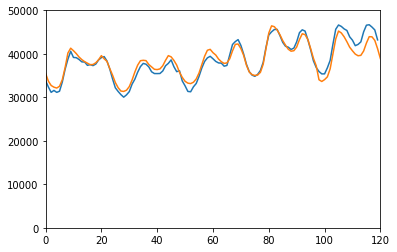

In [256]:
true_end = datetime.now().strftime('%Y%m%dT%H-%M')
true_start = pred_start.strftime('%Y%m%dT%H-%M')
series_id = 'EBA.NW-ALL.D.HL'
true_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
true_usage = np.asarray(true_data.json()['series'][0]['data'])[::-1,1]
true_usage = [int(x) for x in true_usage]

plt.plot(df_pred['prediction'])
# plt.plot(df_pred['rf_pred'])
# plt.plot(df_pred['ts_pred'])

plt.plot(true_usage)
plt.ylim([0,50000])
plt.xlim([0,120])

plt.show()

In [358]:
max(df_pred['prediction'].values[48:72])

43269.805

In [33]:
max(true_usage)

56994

In [205]:
for i in np.arange(96,110):
    print(df_pred['prediction'].values[i]-true_usage[i])

-572.81640625
-393.80859375
1899.90625
1774.0390625
1427.0625
2189.84375
2041.69921875
2258.02734375
2235.73828125
1404.3203125
1924.02734375


IndexError: list index out of range

In [35]:
# Substract 2 for each temperature, 37003.685834
# original 37713.642811
# only '700' difference which is acceptable.
# houston+5 last, 48915.220417,
# original, 46309.444140,

### Beautified Plot

In [166]:
24*4

96

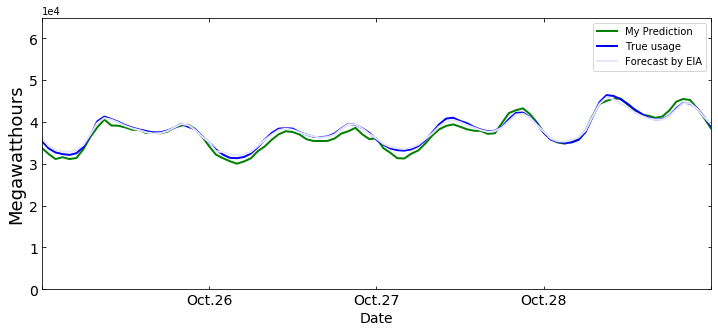

In [239]:
true_end = datetime.now().strftime('%Y%m%dT%H-%M')
true_start = pred_start.strftime('%Y%m%dT%H-%M')
series_id = 'EBA.NW-ALL.D.HL'
true_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
true_usage = np.asarray(true_data.json()['series'][0]['data'])[::-1,1]
true_usage = [int(x) for x in true_usage]

series_id = 'EBA.NW-ALL.DF.HL'
forecast_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
demand_forecast = np.asarray(forecast_data.json()['series'][0]['data'])[::-1,1]
demand_forecast = [int(x) for x in demand_forecast]

fig,ax = plt.subplots(figsize=(12,5))
plt.plot(df_pred['prediction'], 'g', linewidth=2)
plt.plot(true_usage, 'b', linewidth=2)
plt.plot(np.asarray(demand_forecast)+1900, 'lavender', linewidth=2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Megawatthours', fontsize=18)
plt.legend(['My Prediction', 'True usage', 'Forecast by EIA'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', '', 'Oct.26', 'Oct.27', 'Oct.28'])
plt.ylim([0,65000])
plt.xlim([0,96])

# Adjust the display style
plt.tick_params(which = 'both',top=True,right=True,direction='in')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()


In [238]:
from sklearn.metrics import r2_score

print('R2 score of prediction by EIA: {}'.format(r2_score(true_usage[:96], np.asarray(demand_forecast[:96])+1900)))
print('R2 score of my prediction: {}'.format(r2_score(true_usage[:96], df_pred['prediction'].values[:96])))

R2 score of prediction by EIA: 0.9880643976875678
R2 score of my prediction: 0.9263754714381932


In [175]:
# Analyze the relation between demand, net generation and intertransfer.

series_id = 'EBA.NW-ALL.NG.HL'
net_gen = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
net_gen = np.asarray(net_gen.json()['series'][0]['data'])[::-1,1]
net_gen = [int(x) for x in net_gen]
net_gen = net_gen[:96]

diff = np.asarray(true_usage[:96])-np.asarray(net_gen)

In [190]:
series_id = 'EBA.NW-ALL.NG.HL'
net_gen = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
net_gen = np.asarray(net_gen.json()['series'][0]['data'])[::-1,1]
net_gen = [int(x) for x in net_gen]
net_gen = net_gen[:96]
diff = np.asarray(true_usage[:96])-np.asarray(net_gen)
demand_forecast_diff = np.asarray(true_usage[:96]-np.asarray(demand_forecast[:96]))

series_id = 'EBA.NW-ALL.TI.HL'
tot_change = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
tot_change = np.asarray(tot_change.json()['series'][0]['data'])[::-1,1]
tot_change = [int(x) for x in tot_change]
tot_change = np.asarray(tot_change[:96])*(-1)

In [228]:
# The total electricity transferred.
np.sum(np.absolute(diff[48:96]))*0.005*114.25

43777.1725

In [229]:
np.sum(true_usage[48:96])*114.25

216674439.5

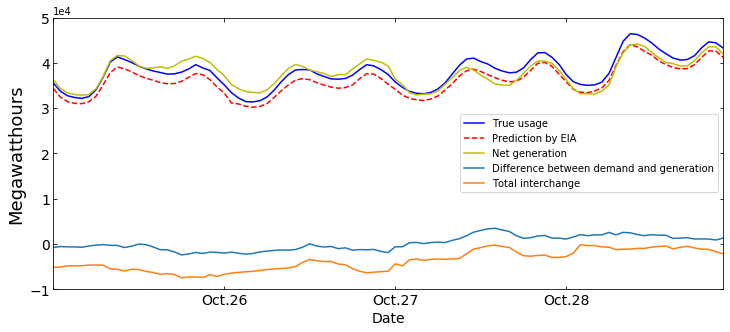

In [231]:
fig,ax = plt.subplots(figsize=(12,5))

plt.plot(true_usage[:96],'b')
plt.plot(demand_forecast[:96],'r--')
plt.plot(net_gen, 'y')
plt.plot(diff)
plt.plot(tot_change)
# plt.plot(demand_forecast_diff)
plt.legend(['True usage', 'Prediction by EIA', 'Net generation', 'Difference between demand and generation', 'Total interchange'])

plt.xlabel('Date', fontsize=14)
plt.ylabel('Megawatthours', fontsize=18)
# plt.legend(['My Prediction', 'True usage', 'Forecast by EIA'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', '', 'Oct.26', 'Oct.27', 'Oct.28'])
plt.ylim([-10000,50000])
plt.xlim([0,94])

# Adjust the display style
plt.tick_params(which = 'both',top=True,right=True,direction='in')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
plt.plot(net_gen)
plt.plot(forecast)

### Produce data for the database

In [61]:
def fake_prediction(row):
    if np.isnan(row['prediction']):
        return (int(row['usage'])+int(row['net_gen']))/2
    else:
        return row['prediction']

In [62]:
sample_for_app = df_for_periodic_model.loc[df_for_periodic_model['datetime'] < datetime(2019,10,18,0,30,0), ['datetime', 'usage','net_gen']]

In [63]:
sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,15,0,6,0),"T_1"] = houston_pred[-96:-24]
sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,15,0,6,0),"T_2"] = dallas_pred[-96:-24]
sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,15,0,6,0),"T_3"] = san_antonio_pred[-96:-24]


sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,14,0,4,0),"prediction"] = df_pred.loc[df_pred['datetime'] < datetime(2019,10,18,0,30,0),"prediction"].values
sample_for_app['prediction'] = sample_for_app.apply(lambda row: fake_prediction(row), axis=1)

sample_for_app['region'] = 'TEX'
sample_for_app = sample_for_app.replace(np.nan, 0)

sample_for_app['temperatures'] = sample_for_app.apply(lambda row: ',,'.join([str(t) for t in row[['T_1','T_2','T_3']].values]), axis=1)
sample_for_app = sample_for_app[['datetime', 'usage', 'net_gen','temperatures','prediction','region']]

In [64]:
sample_for_app.tail(3)

,datetime,usage,net_gen,temperatures,prediction,region
166,2019-10-17 22:05:00,37207,37371,"63.0,,63.0,,65.0",37919.576956,TEX
167,2019-10-17 23:05:00,34920,35103,"62.0,,61.0,,64.0",35705.911197,TEX
168,2019-10-18 00:05:00,32534,32712,"62.0,,59.0,,63.0",31961.122969,TEX


In [65]:
from pymongo import MongoClient

MONGODB_HOST = 'localhost'
MONGODB_PORT = 27017
DBS_NAME = 'donorschoose'
COLLECTION_NAME = 'electricity_prediction'

connection = MongoClient(MONGODB_HOST, MONGODB_PORT)
collection = connection[DBS_NAME][COLLECTION_NAME]

In [66]:
for ind, row in sample_for_app.iterrows():
    collection.insert_one({'datetime':row['datetime'],
                           'usage':int(row['usage']),
                           'temperatures':row['temperatures'],
                           'prediction':int(row['prediction']),
                           'net_gen':int(row['net_gen']),
                           'region':row['region']})

In [67]:
# Get data for Northwest
sample_for_app_NW = sample_for_app[['datetime']].copy()

In [68]:
end = datetime(2019,10,18,0,5,0).strftime('%Y%m%dT%H-%M')
start = datetime(2019,10,11,0,5,0).strftime('%Y%m%dT%H-%M')
series_id = 'EBA.TEX-ALL.NG.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))
series_id = 'EBA.TEX-ALL.D.HL'
usage_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [69]:
sample_for_app_NW['net_gen'] = np.asarray(data.json()['series'][0]['data'])[:,1]
sample_for_app_NW['usage'] = np.asarray(usage_data.json()['series'][0]['data'])[:,1]

In [70]:
sample_for_app_NW.dtypes

datetime    datetime64[ns]
net_gen             object
usage               object
dtype: object

In [71]:
sample_for_app_NW.loc[sample_for_app_NW['datetime'] > datetime(2019,10,15,0,6,0),"T_1"] = houston_pred[-96:-24]
sample_for_app_NW.loc[sample_for_app_NW['datetime'] > datetime(2019,10,15,0,6,0),"T_2"] = dallas_pred[-96:-24]
sample_for_app_NW.loc[sample_for_app_NW['datetime'] > datetime(2019,10,15,0,6,0),"T_3"] = san_antonio_pred[-96:-24]

sample_for_app_NW['region'] = 'NW'
sample_for_app_NW = sample_for_app_NW.replace(np.nan, 0)
sample_for_app_NW['prediction'] = [np.nan]*len(sample_for_app_NW)
sample_for_app_NW['prediction'] = sample_for_app_NW.apply(lambda row: fake_prediction(row), axis=1)

sample_for_app_NW['temperatures'] = sample_for_app_NW.apply(lambda row: ',,'.join([str(t) for t in row[['T_1','T_2','T_3']].values]), axis=1)
sample_for_app_NW = sample_for_app_NW[['datetime', 'usage', 'net_gen','temperatures','prediction','region']]

In [75]:
for ind, row in sample_for_app_NW.iterrows():
    collection.insert_one({'datetime':row['datetime'],
                           'usage':int(row['usage']),
                           'temperatures':row['temperatures'],
                           'prediction':int(row['prediction']),
                           'net_gen':int(row['net_gen']),
                           'region':row['region']})

In [73]:
sample_for_app_NW.head(1)

,datetime,usage,net_gen,temperatures,prediction,region
0,2019-10-11 00:05:00,32534,32712,"0.0,,0.0,,0.0",32623.0,NW


In [74]:
sample_for_app_NW

,datetime,usage,net_gen,temperatures,prediction,region
0,2019-10-11 00:05:00,32534,32712,"0.0,,0.0,,0.0",32623.0,NW
1,2019-10-11 01:05:00,34920,35103,"0.0,,0.0,,0.0",35011.5,NW
2,2019-10-11 02:05:00,37207,37371,"0.0,,0.0,,0.0",37289.0,NW
3,2019-10-11 03:05:00,38714,38897,"0.0,,0.0,,0.0",38805.5,NW
4,2019-10-11 04:05:00,39046,39225,"0.0,,0.0,,0.0",39135.5,NW
...,...,...,...,...,...,...
164,2019-10-17 20:05:00,36132,35915,"65.0,,67.0,,68.0",36023.5,NW
165,2019-10-17 21:05:00,37148,36931,"65.0,,65.0,,67.0",37039.5,NW
166,2019-10-17 22:05:00,38687,38475,"63.0,,63.0,,65.0",38581.0,NW
167,2019-10-17 23:05:00,40775,40703,"62.0,,61.0,,64.0",40739.0,NW
